<a href="https://colab.research.google.com/github/sanuj/tf-basics/blob/master/boston_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


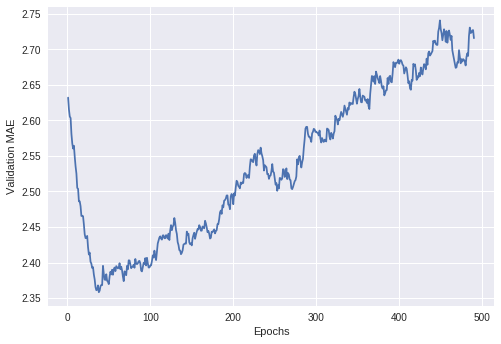

102/102 [==============================] - 0s 3ms/step
Test MSE Score:  19.760635375976562
Test MAE Score:  2.9635661630069507


In [9]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

# normalize data
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

# Build model
from keras import models
from keras import layers

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu',
                         input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

# k-fold validation to find optimal epoch
import numpy as np
k = 4
num_val_samples = len(train_data) // k
all_scores = []

num_epochs = 500
all_mae_histories = []
for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                       train_data[(i + 1) * num_val_samples:]],axis=0)
  partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                          train_targets[(i + 1) * num_val_samples:]],axis=0)
  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets,
                      validation_data=(val_data, val_targets),epochs=num_epochs,
                      batch_size=1, verbose=0)
  mae_history = history.history['val_mean_absolute_error']
  all_mae_histories.append(mae_history)

average_mae_history = [np.mean([x[i] for x in all_mae_histories])
                       for i in range(num_epochs)]

# plotting the smooth MAE
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points


smooth_mae_history = smooth_curve(average_mae_history[10:])


import matplotlib.pyplot as plt
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print('Test MSE Score: ', test_mse_score)
print('Test MAE Score: ', test_mae_score)